In [43]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud

## LDA Method:

In [2]:
# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /Users/rick/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /Users/rick/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/rick/nltk_data...


True

In [19]:
# Load dataset
df = pd.read_csv("bbc_text_cls.csv")

In [16]:
# Initialize NLP tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [17]:
# Extend stopwords
extra_stopwords = set(["said", "year", "people", "best", "game", "award", "film", "party", "company"])
stop_words = set(stopwords.words('english')).union(extra_stopwords)

In [18]:
def preprocess_text(text):
    """Text preprocessing function: Lowercase, remove special chars, lemmatize"""
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    words = word_tokenize(text)  # Tokenization
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and len(word) > 2]  # Remove stopwords & lemmatize
    return " ".join(words)

In [20]:
# Apply preprocessing
df["clean_text"] = df["text"].apply(preprocess_text)

In [21]:
# Use CountVectorizer with bigrams for better topic representation
vectorizer = CountVectorizer(max_df=0.9, min_df=5, stop_words="english", ngram_range=(1,2))
X = vectorizer.fit_transform(df["clean_text"])

In [22]:
# Train LDA model
num_topics = 5  # Adjust if needed
# Train LDA model
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(X)

LatentDirichletAllocation(n_components=5, random_state=42)

In [24]:
# Display topics with better words
def display_topics(model, feature_names, num_words=10):
    """Displays top words per topic."""
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        words = [feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]]
        topic_dict[f"Topic {topic_idx}"] = words
        print(f"📝 Topic {topic_idx}: {', '.join(words)}")
    return topic_dict

In [26]:
# Print refined topics
topic_words = display_topics(lda_model, vectorizer.get_feature_names_out())

📝 Topic 0: time, world, win, club, player, music, new, final, play, second
📝 Topic 1: firm, share, new, sale, deal, software, market, site, group, bank
📝 Topic 2: mobile, technology, phone, market, service, new, economy, growth, month, rate
📝 Topic 3: government, labour, election, minister, blair, say, tory, new, plan, told
📝 Topic 4: game, england, star, time, wale, player, award, actor, half, director


In [27]:
# Assign dominant topic to each document
df["dominant_topic"] = lda_model.transform(X).argmax(axis=1)

In [31]:
## WE Map based on LDA top words:
topic_names = {
    0: "Sports & Music",
    1: "Business & Finance",
    2: "Technology & Industry",
    3: "Politics & Government",
    4: "Entertainment & Sports"
}

In [30]:
df["topic_name"] = df["dominant_topic"].map(topic_names)

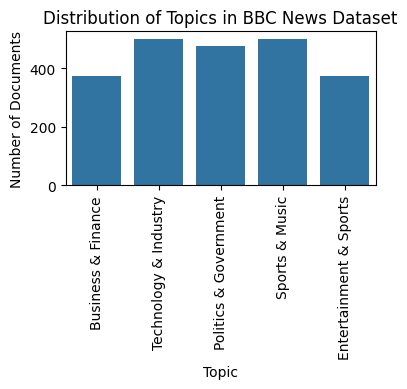

In [38]:
import seaborn as sns

# Plot topic distribution
plt.figure(figsize=(4,2))
sns.countplot(x=df["topic_name"])
plt.xlabel("Topic")
plt.ylabel("Number of Documents")
plt.xticks(rotation=90)
plt.title("Distribution of Topics in BBC News Dataset")
plt.show()

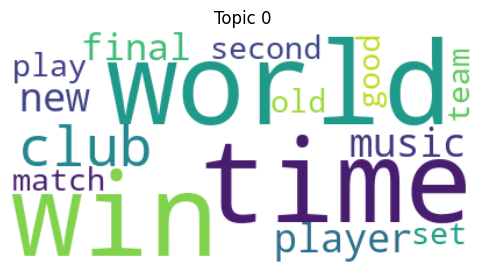

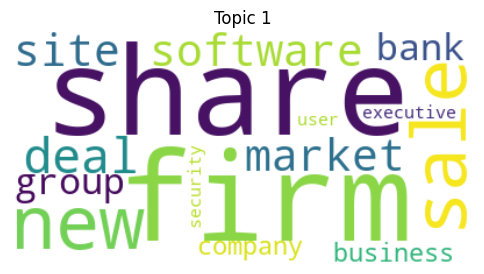

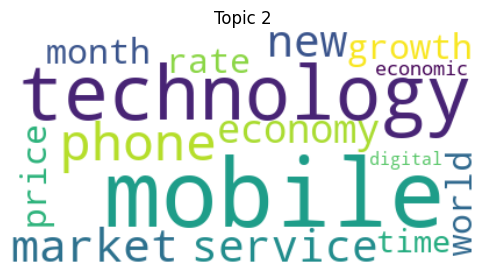

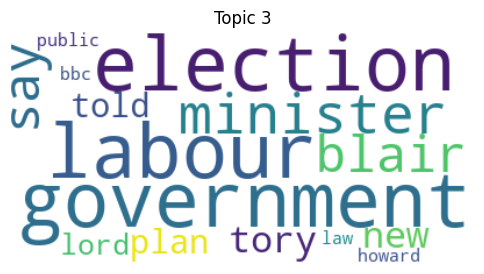

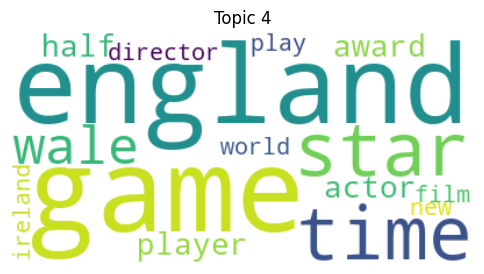

In [44]:
# Generate word clouds for each topic
def plot_word_clouds(model, feature_names, num_topics):
    for topic_idx, topic in enumerate(model.components_):
        wordcloud = WordCloud(background_color='white').generate(" ".join([feature_names[i] for i in topic.argsort()[:-15 - 1:-1]]))
        plt.figure(figsize=(6,6))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Topic {topic_idx}")
        plt.show()

# Display word clouds
plot_word_clouds(lda_model, vectorizer.get_feature_names_out(), num_topics)

In [45]:
# Save results
df.to_csv("bbc_lda_topics.csv", index=False)

### NPMI and TD Calculations

In [50]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary

In [51]:
feature_names = vectorizer.get_feature_names_out()
topics = []
for topic in lda_model.components_:
    words = [feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]  # Top 10 words
    topics.append(words)

In [59]:
def preprocess_text(text):
    """Function to clean and preprocess text."""
    text = text.lower()  # Lowercase
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    words = word_tokenize(text)  # Tokenization
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and len(word) > 2]  # Lemmatization
    return words  # Return as a list (needed for gensim)

In [60]:
df["clean_text"] = df["text"].apply(lambda x: preprocess_text(x))  # Ensure it returns a list

In [62]:
# Compute NPMI Coherence Score
id2word = Dictionary(df["clean_text"])  # Create a dictionary for Gensim
corpus = [id2word.doc2bow(text) for text in df["clean_text"]]  # Convert text to BoW format

In [64]:
coherence_model = CoherenceModel(topics=topics, texts=df["clean_text"], dictionary=id2word, coherence='c_npmi')
npmi_score = coherence_model.get_coherence()

In [67]:
# Compute Topic Diversity (TD) Score
unique_words = set(word for topic in topics for word in topic)  # Unique words across topics
total_words = num_topics * 10  # Total top words (assuming 10 words per topic)
td_score = len(unique_words) / total_words  # TD = Unique words / Total words


In [68]:
# Display Results
print(f"🔹 NPMI Coherence Score: {npmi_score:.4f}")
print(f"🔹 Topic Diversity (TD) Score: {td_score:.4f}")

🔹 NPMI Coherence Score: 0.0174
🔹 Topic Diversity (TD) Score: 0.8800


In [69]:
# Save results
results = {
    "NPMI Score": npmi_score,
    "Topic Diversity": td_score
}
pd.DataFrame([results]).to_csv("bbc_lda_evaluation.csv", index=False)

## NMF Method:

In [70]:
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from wordcloud import WordCloud

In [71]:
# Load dataset
df = pd.read_csv("bbc_text_cls.csv")

In [72]:
# Apply preprocessing
df["clean_text"] = df["text"].apply(lambda x: preprocess_text(x))

In [73]:
# Convert text to TF-IDF representation
vectorizer = TfidfVectorizer(max_df=0.9, min_df=5, stop_words="english", ngram_range=(1,2))
X = vectorizer.fit_transform(df["clean_text"].apply(lambda words: " ".join(words)))


In [74]:
# Train NMF model
num_topics = 5
nmf_model = NMF(n_components=num_topics, random_state=42)
W = nmf_model.fit_transform(X)
H = nmf_model.components_

In [75]:
# Extract topic words
feature_names = vectorizer.get_feature_names_out()
topics = []
for topic in H:
    words = [feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]  # Top 10 words
    topics.append(words)

In [76]:
# Compute NPMI Coherence Score
id2word = Dictionary(df["clean_text"])  # Create dictionary for Gensim
corpus = [id2word.doc2bow(text) for text in df["clean_text"]]  # Convert text to BoW format


In [77]:
coherence_model = CoherenceModel(topics=topics, texts=df["clean_text"], dictionary=id2word, coherence='c_npmi')
npmi_score = coherence_model.get_coherence()

In [78]:
# Compute Topic Diversity (TD) Score
unique_words = set(word for topic in topics for word in topic)  # Unique words across topics
total_words = num_topics * 10  # Total top words (assuming 10 words per topic)
td_score = len(unique_words) / total_words  # TD = Unique words / Total words

In [79]:
# Display Results
print(f"🔹 NPMI Coherence Score: {npmi_score:.4f}")
print(f"🔹 Topic Diversity (TD) Score: {td_score:.4f}")

🔹 NPMI Coherence Score: 0.1430
🔹 Topic Diversity (TD) Score: 0.9800


In [80]:
# Save results
results = {
    "NPMI Score": npmi_score,
    "Topic Diversity": td_score
}
pd.DataFrame([results]).to_csv("bbc_nmf_evaluation.csv", index=False)

print("✅ NMF evaluation metrics saved in 'bbc_nmf_evaluation.csv'.")

✅ NMF evaluation metrics saved in 'bbc_nmf_evaluation.csv'.


### Bertopic:

In [2]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from bertopic import BERTopic
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from wordcloud import WordCloud

In [3]:
# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Load dataset
df = pd.read_csv("bbc_text_cls.csv")

# Extend stopwords
extra_stopwords = {"said", "year", "people", "new", "time", "play", "told"}
stop_words = set(stopwords.words('english')).union(extra_stopwords)

# Initialize NLP tools
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """Function to clean and preprocess text."""
    text = text.lower()  # Lowercase
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    words = word_tokenize(text)  # Tokenization
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and len(word) > 2]  # Lemmatization
    return " ".join(words)  # Return string format for BERTopic

# Apply preprocessing
df["clean_text"] = df["text"].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /Users/rick/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/rick/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/rick/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
# Train BERTopic Model
topic_model = BERTopic(language="english", verbose=True, calculate_probabilities=True)
topics, probs = topic_model.fit_transform(df["clean_text"])

2025-02-21 16:14:55,473 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/70 [00:00<?, ?it/s]

2025-02-21 16:15:23,123 - BERTopic - Embedding - Completed ✓
2025-02-21 16:15:23,124 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-02-21 16:15:29,005 - BERTopic - Dimensionality - Completed ✓
2025-02-21 16:15:29,006 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-02-21 16:15:29,141 - BERTopic - Cluster - Completed ✓
2025-02-21 16:15:29,149 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-02-21 16:15:29,342 - BERTopic - Representation - Completed ✓


In [5]:
# Assign topics to DataFrame
df["topic"] = topics

In [8]:
# Extract top words per topic
topic_info = topic_model.get_topic_info()
topics_dict = topic_model.get_topics()
num_topics = len(topic_info) - 1  # Exclude "-1" topic (outliers)

# Prepare topics for coherence calculation
topics_words = [[word for word, _ in topics_dict[i]] for i in range(num_topics)]


In [9]:
# Compute NPMI Coherence Score
id2word = Dictionary(df["clean_text"].apply(str.split))  # Gensim dictionary
corpus = [id2word.doc2bow(text.split()) for text in df["clean_text"]]  # Convert text to BoW

coherence_model = CoherenceModel(topics=topics_words, texts=df["clean_text"].apply(str.split), dictionary=id2word, coherence='c_npmi')
npmi_score = coherence_model.get_coherence()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [10]:
# Compute Topic Diversity (TD) Score
unique_words = set(word for topic in topics_words for word in topic)  # Unique words across topics
total_words = num_topics * 10  # Total top words (assuming 10 words per topic)
td_score = len(unique_words) / total_words  # TD = Unique words / Total words

In [11]:
# Display Results
print(f"🔹 NPMI Coherence Score: {npmi_score:.4f}")
print(f"🔹 Topic Diversity (TD) Score: {td_score:.4f}")

🔹 NPMI Coherence Score: 0.1562
🔹 Topic Diversity (TD) Score: 0.8553


In [12]:
# Save results
results = {
    "NPMI Score": npmi_score,
    "Topic Diversity": td_score
}
pd.DataFrame([results]).to_csv("bbc_bertopic_evaluation.csv", index=False)

print("✅ BERTopic evaluation metrics saved in 'bbc_bertopic_evaluation.csv'.")

✅ BERTopic evaluation metrics saved in 'bbc_bertopic_evaluation.csv'.


## Bertopic with DeepSeek Embeddings

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import torch
import ollama
import torch
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from transformers import AutoTokenizer, AutoModel
from bertopic import BERTopic
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from wordcloud import WordCloud
from tqdm import tqdm

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Load dataset
df = pd.read_csv("bbc_text_cls.csv")

# Extend stopwords
extra_stopwords = {"said", "year", "people", "new", "time", "play", "told"}
stop_words = set(stopwords.words('english')).union(extra_stopwords)

# Initialize NLP tools
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """Function to clean and preprocess text."""
    text = text.lower()  # Lowercase
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    words = word_tokenize(text)  # Tokenization
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and len(word) > 2]  # Lemmatization
    return " ".join(words)  # Return string format for BERTopic

# Apply preprocessing
df["clean_text"] = df["text"].apply(preprocess_text)

# Load DeepSeek Model
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained("deepseek-ai/deepseek-embed-v1")
model = AutoModel.from_pretrained("deepseek-ai/deepseek-embed-v1").to(device)

# Function to encode sentences using DeepSeek
def get_deepseek_embeddings(texts, batch_size=16):
    """Encodes text using DeepSeek embeddings."""
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i : i + batch_size]
        inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            sentence_embeddings = outputs.last_hidden_state.mean(dim=1)  # Mean pooling
            embeddings.append(sentence_embeddings.cpu().numpy())

    return np.vstack(embeddings)

# Generate DeepSeek embeddings for the dataset
embeddings = get_deepseek_embeddings(df["clean_text"].tolist())

# Train BERTopic Model with DeepSeek Embeddings
topic_model = BERTopic(language="english", embedding_model=embeddings, verbose=True)
topics, probs = topic_model.fit_transform(df["clean_text"], embeddings)

# Assign topics to DataFrame
df["topic"] = topics

# Extract top words per topic
topic_info = topic_model.get_topic_info()
topics_dict = topic_model.get_topics()
num_topics = len(topic_info) - 1  # Exclude "-1" topic (outliers)

# Prepare topics for coherence calculation
topics_words = [[word for word, _ in topics_dict[i]] for i in range(num_topics)]

# Compute NPMI Coherence Score
id2word = Dictionary(df["clean_text"].apply(str.split))  # Gensim dictionary
corpus = [id2word.doc2bow(text.split()) for text in df["clean_text"]]  # Convert text to BoW

coherence_model = CoherenceModel(topics=topics_words, texts=df["clean_text"].apply(str.split), dictionary=id2word, coherence='c_npmi')
npmi_score = coherence_model.get_coherence()

# Compute Topic Diversity (TD) Score
unique_words = set(word for topic in topics_words for word in topic)  # Unique words across topics
total_words = num_topics * 10  # Total top words (assuming 10 words per topic)
td_score = len(unique_words) / total_words  # TD = Unique words / Total words

# Display Results
print(f"🔹 NPMI Coherence Score: {npmi_score:.4f}")
print(f"🔹 Topic Diversity (TD) Score: {td_score:.4f}")

# Save results
results = {
    "NPMI Score": npmi_score,
    "Topic Diversity": td_score
}
pd.DataFrame([results]).to_csv("bbc_deepseek_bertopic_evaluation.csv", index=False)

print("✅ DeepSeek + BERTopic evaluation metrics saved in 'bbc_deepseek_bertopic_evaluation.csv'.")

# Visualize Topic Distributions
topic_model.visualize_barchart(top_n_topics=10)
